In [57]:
%matplotlib nbagg
import numpy as np
import json
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy.special import erf
from scipy.optimize import curve_fit
import os

In [58]:
channel_PIPS_trans = "data/SARES11-GES1:CH1_VAL_GET/data"           #X-ray diode to PRIME Keysight
channel_PIPS_fluo = "data/SARES11-GES1:CH2_VAL_GET/data"           #X-ray diode to PRIME Keysight
channel_Izero = "data/SARES11-LSCP10-FNS:CH2:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 3)
channel_Izero2 = "data/SARES11-LSCP10-FNS:CH3:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 0)
channel_Izero3 = "data/SARES11-LSCP10-FNS:CH1:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 1)
channel_Izero4 = "data/SARES11-LSCP10-FNS:CH2:VAL_GET/data"         #Izero diode to PRIME Ioxos (channel 2)
channel_LaserDiode = "data/SLAAR11-LSCP1-FNS:CH0:VAL_GET/data"      #Laser diode to ESA Laser Ioxos 
channel_Laser_refDiode = "data/SLAAR11-LSCP1-FNS:CH2:VAL_GET/data"  #Laser diode leaking from beampath, to ESA Laser Ioxos 
#channel_LaserDiode = "SARES11-GES1:CH2_VAL_GET/data"          #Laser diode to PRIME Keysight
channel_pulse_ids = "data/SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)
channel_delay = "data/SLAAR11-LMOT-M451:ENC_1_BS/data"              #Delay of pump-probe delay stage
channel_LAM_delaystage = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"       #LAM internal stage position in mm
channel_LAM_stepper = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV10_NBS/data"         #LAM stepper motor (used for feedback)
channel_PALM_eTOF = "data/SAROP11-PALMK118:CH2_BUFFER/data"                 #PALM eTof from Ch2

#Position of the stage: Dummy PV1 for x axis, dummy PV3 for y axis
channel_position = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV1_NBS/data"     #Huber stage X position. 
channel_position = "data/SLAAR11-LMOT-M451:ENC_1_BS/data"
channel_energy = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV3_NBS/data"       #Energy from the monochromator

In [59]:
scan_name ="CytC_Fe3_monoscan_complete_002"
#scan_name ="CytC_Fe2_7122eV_delayscan_002"

# file names of the type below. copy paste for ease:
# FEL_knife_edge_Y_coarse_
# FEL_knife_edge_X_coarse_
# FEL_knife_edge_Y_fine_
# FEL_knife_edge_X_fine_

DIR = "/sf/alvra/data/p17803/raw/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p17803/res/scan_info/"

In [60]:
def LoadData_knife_edge(filename):
    with h5py.File(filename, 'r') as BS_file:
        pulse_ids = BS_file[channel_pulse_ids][:]
        reprate_FEL = ((pulse_ids%4 == 0) & (pulse_ids%8 != 0))                #This is for 25 Hz
        reprate_laser = pulse_ids%8 == 0                                       #This is for 12.5 Hz
        
        Data_pumped = BS_file[channel_PIPS_fluo][:][reprate_laser]
        Data_unpumped = BS_file[channel_PIPS_fluo][:][reprate_FEL]
        
        DataT_pumped = BS_file[channel_PIPS_trans][:][reprate_laser]
        DataT_unpumped = BS_file[channel_PIPS_trans][:][reprate_FEL]
        
        Izero_pump = BS_file[channel_Izero][:][reprate_laser]
        Izero_unpump = BS_file[channel_Izero][:][reprate_FEL]
        
        Energy = BS_file[channel_energy][:][reprate_FEL]
        Position = BS_file[channel_position][:][reprate_FEL]
        
    return Data_pumped, Data_unpumped, Izero_pump, Izero_unpump, Energy, Position, DataT_pumped, DataT_unpumped

def errfunc(x, a, b, c, d):
    return a + b*erf((c-x)*np.sqrt(np.log(2))/(np.abs(d)))

In [61]:
!ls -lah -rt $DIR
!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 1.6T
drwxrwsr-x. 48 root p17803 4.0K Jan 23 10:13 ..
-rw-r--r--.  1 root p17803  18G Jan 23 10:14 CytC_Fe3_monoscan_complete_002_step0000.JF02T09V01.h5
-rw-r--r--.  1 root p17803 6.1M Jan 23 10:15 CytC_Fe3_monoscan_complete_002_step0000.BSREAD_CA.h5
-rw-r--r--.  1 root p17803  18G Jan 23 10:16 CytC_Fe3_monoscan_complete_002_step0001.JF02T09V01.h5
-rw-r--r--.  1 root p17803 827M Jan 23 10:16 CytC_Fe3_monoscan_complete_002_step0000.BSREAD.h5
-rw-r--r--.  1 root p17803 6.2M Jan 23 10:16 CytC_Fe3_monoscan_complete_002_step0001.BSREAD_CA.h5
-rw-r--r--.  1 root p17803  18G Jan 23 10:17 CytC_Fe3_monoscan_complete_002_step0002.JF02T09V01.h5
-rw-r--r--.  1 root p17803 6.0M Jan 23 10:17 CytC_Fe3_monoscan_complete_002_step0002.BSREAD_CA.h5
-rw-r--r--.  1 root p17803 827M Jan 23 10:18 CytC_Fe3_monoscan_complete_002_step0001.BSREAD.h5
-rw-r--r--.  1 root p17803  18G Jan 23 10:19 CytC_Fe3_monoscan_complete_002_step0003.JF02T09V01.h5
-rw-r--r--.  1 root p17803 827M Jan 23 10:19 CytC_Fe3_monosca

ra-c-004.psi.ch
There are 260 files in the folder /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_monoscan_complete_002/


In [62]:
json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")

Signal_pump = []
Signal_unpump = []
err_signal = []

SignalT_pump = []
SignalT_unpump = []
err_signalT = []

Izero_pump = []
Izero_unpump = []
err_Izero = []
Izero_loop = []

Position_mm = []
Energy_eV = []

for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])    
    exists = os.path.isfile(filename)
    if exists:
        print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
        (signal_pump_loop,signal_unpump_loop,Izero_pump_loop, Izero_unpump_loop,energy_loop,position_loop,\
         signalT_pump_loop,signalT_unpump_loop) = LoadData_knife_edge(str(data['scan_files'][i][0]))
        Signal_pump.append(np.mean(signal_pump_loop))
        Signal_unpump.append(signal_unpump_loop.mean())
        err_signal.append(signal_pump_loop.std()/np.sqrt(signal_pump_loop.size))
        
        SignalT_pump.append(np.mean(signalT_pump_loop))
        SignalT_unpump.append(signalT_unpump_loop.mean())
        err_signalT.append(signalT_pump_loop.std()/np.sqrt(signalT_pump_loop.size))
        
        Izero_pump.append(Izero_pump_loop.mean())
        Izero_unpump.append(Izero_unpump_loop.mean())
       # err_Izero.append(Izero_loop.std()/np.sqrt(Izero_loop.size))
    
        energy_loop = [x for x in energy_loop if (np.abs(x) > 0)]
        Energy_eV.append(np.mean(energy_loop))
        Position_mm.append(np.mean(position_loop))
        
        print (signal_pump_loop.size,signal_unpump_loop.size)
    
Signal_pump = np.asarray(Signal_pump)
Signal_unpump = np.asarray(Signal_unpump)
err_signal = np.asarray(err_signal)

SignalT_pump = np.asarray(SignalT_pump)
SignalT_unpump = np.asarray(SignalT_unpump)
err_signalT = np.asarray(err_signalT)

Izero_pump = np.asarray(Izero_pump)
Izero_unpump = np.asarray(Izero_unpump)
err_Izero = np.asarray(err_Izero)

Energy_eV = np.asarray(Energy_eV)
Position_mm = np.asarray(Position_mm)
print ("Job done!")

/sf/alvra/data/p17803/res/scan_info/CytC_Fe3_monoscan_complete_002_scan_info.json
Processing 87 files
step 1 of 87 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_monoscan_complete_002/CytC_Fe3_monoscan_complete_002_step0000.BSREAD.h5
1000 1000
step 2 of 87 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_monoscan_complete_002/CytC_Fe3_monoscan_complete_002_step0001.BSREAD.h5
1000 1000
step 3 of 87 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_monoscan_complete_002/CytC_Fe3_monoscan_complete_002_step0002.BSREAD.h5
1000 1000
step 4 of 87 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_monoscan_complete_002/CytC_Fe3_monoscan_complete_002_step0003.BSREAD.h5
1000 1000
step 5 of 87 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_monoscan_complete_002/CytC_Fe3_monoscan_complete_002_step0004.BSREAD.h5
1000 1000
step 6 of 87 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_monoscan_complete_002/CytC_Fe3_monoscan_complete_002_step0005.

1000 1000
step 64 of 87 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_monoscan_complete_002/CytC_Fe3_monoscan_complete_002_step0063.BSREAD.h5
1000 1000
step 65 of 87 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_monoscan_complete_002/CytC_Fe3_monoscan_complete_002_step0064.BSREAD.h5
1000 1000
step 66 of 87 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_monoscan_complete_002/CytC_Fe3_monoscan_complete_002_step0065.BSREAD.h5
1000 1000
step 67 of 87 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_monoscan_complete_002/CytC_Fe3_monoscan_complete_002_step0066.BSREAD.h5
1000 1000
step 68 of 87 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_monoscan_complete_002/CytC_Fe3_monoscan_complete_002_step0067.BSREAD.h5
1000 1000
step 69 of 87 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_monoscan_complete_002/CytC_Fe3_monoscan_complete_002_step0068.BSREAD.h5
1000 1000
step 70 of 87 : Processing /sf/alvra/data/p17803/raw/scan_data/Cyt

1.1973076055281067
(1000, 1)


<IPython.core.display.Javascript object>


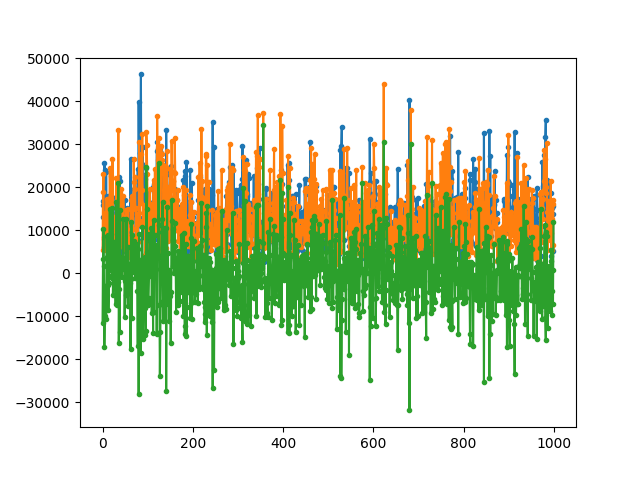

40.317277227723025


In [7]:
print (signal_pump_loop.mean())
print (signal_unpump_loop.shape)
plt.figure()

plt.plot(Izero_pump_loop, label="FEL+Laser",marker='.')
plt.plot(Izero_unpump_loop, label="FEL+Laser",marker='.')
plt.plot(Izero_unpump_loop-Izero_pump_loop, label="FEL+Laser",marker='.')

print (Izero_pump_loop.mean()- Izero_unpump_loop.mean())

<IPython.core.display.Javascript object>


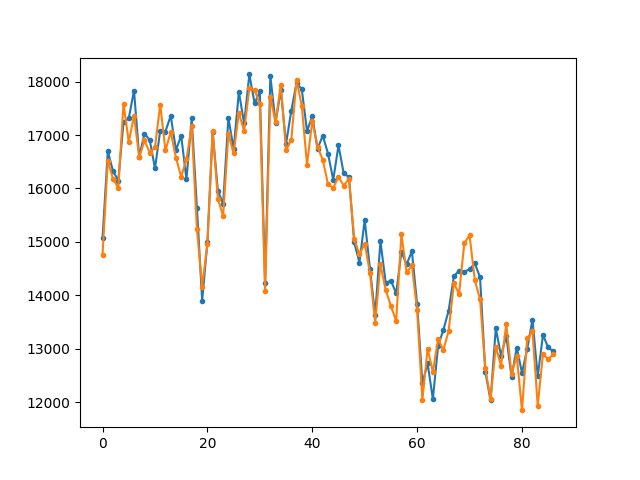

In [8]:
plt.figure()

plt.plot(Izero_pump, label="FEL+Laser",marker='.')
plt.plot(Izero_unpump, label="FEL+Laser",marker='.')

In [63]:
Signal_pump_norm = Signal_pump / Izero_pump
Signal_unpump_norm = Signal_unpump / Izero_unpump

SignalT_pump_norm = SignalT_pump / Izero_pump
SignalT_unpump_norm = SignalT_unpump / Izero_unpump

#Signal_pump_norm = np.log(-(Signal_pump / Izero_pump))
#Signal_unpump_norm = np.log(-(Signal_unpump / Izero_unpump))


#Signal_pump = Signal_pump 
#Signal_unpump_norm = Signal_unpump 

err_signal_norm = err_signal / Izero_pump
err_signalT_norm = err_signalT / Izero_pump

In [64]:
# Optional to run --> it returns the maximum value of the trace

m=max(Signal_pump_norm-Signal_unpump_norm)
print(m)
[i for i, j in enumerate(Signal_pump_norm-Signal_unpump_norm) if j==m] # returns the location in x axis indexes of the max
print(Energy_eV[42])
print(Position_mm)

1.3986067959654192e-08
7122.053831885034
[150.54999945 150.55000225 150.54999885 150.55000345 150.54999825
 150.54999945 150.55000075 150.54999945 150.55000025 150.54999815
 150.55000105 150.55000305 150.55000185 150.54999905 150.54999715
 150.54999885 150.54999825 150.54999785 150.54999585 150.55000035
 150.55000425 150.55000055 150.54999805 150.54999605 150.55000115
 150.54999755 150.55000065 150.55000565 150.54999935 150.54999705
 150.54999895 150.55000015 150.55000165 150.54999915 150.54999655
 150.54999755 150.55000125 150.54999445 150.54999795 150.54999965
 150.55000255 150.54999745 150.55000165 150.55000265 150.54999985
 150.55000075 150.54999895 150.54999805 150.55000535 150.54999945
 150.54999505 150.54999995 150.55000295 150.54999725 150.55000095
 150.55000295 150.54999835 150.54999955 150.55000175 150.55000065
 150.55000145 150.55000185 150.55000005 150.55000415 150.54999725
 150.55000065 150.55000145 150.54999545 150.55000175 150.54999975
 150.55000005 150.54999815 150.5500

<IPython.core.display.Javascript object>


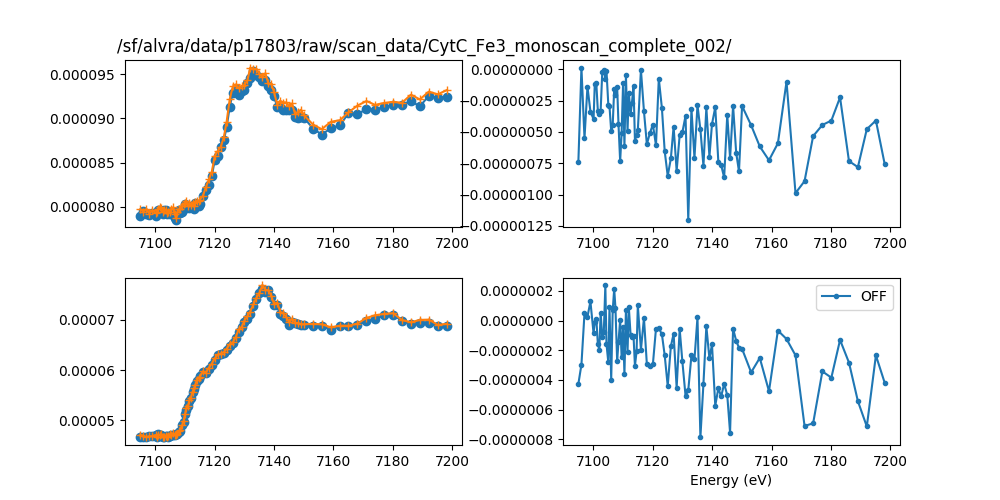

In [65]:
plt.figure(figsize = (10,5))

plt.subplot(2,2,1)
plt.plot(Energy_eV, Signal_pump_norm, label="ON",marker='o')
plt.plot(Energy_eV, Signal_unpump_norm, label="OFF",marker='+')
low_err= Signal_pump_norm - err_signal_norm
high_err= Signal_pump_norm + err_signal_norm
#plt.fill_between(Energy_eV, low_err, high_err, color='lightblue')


plt.subplot(2,2,2)
plt.plot(Energy_eV,(Signal_pump_norm-Signal_unpump_norm), label="OFF",marker='.')
#plt.plot(Position_mm, [-0.0000004]*len(Position_mm) , label="OFF")

plt.title(DIR,horizontalalignment='right')


plt.subplot(2,2,3)
plt.plot(Energy_eV, SignalT_pump_norm, label="ON",marker='o')
plt.plot(Energy_eV, SignalT_unpump_norm, label="OFF",marker='+')
#plt.fill_between(Energy_eV, low_err, high_err, color='lightblue')

plt.subplot(2,2,4)
plt.plot(Energy_eV, SignalT_pump_norm-SignalT_unpump_norm, label="OFF",marker='.')


#plt.xlabel("Position (mm)")
plt.xlabel("Energy (eV)")
plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.3,hspace = 0.3) 
plt.show()

#plt.savefig('Timescan_7_diode')

In [66]:
scan_name ="CytC_Fe2_monoscan_complete_009"
#scan_name ="CytC_Fe2_7122eV_delayscan_002"

# file names of the type below. copy paste for ease:
# FEL_knife_edge_Y_coarse_
# FEL_knife_edge_X_coarse_
# FEL_knife_edge_Y_fine_
# FEL_knife_edge_X_fine_

DIR = "/sf/alvra/data/p17803/raw/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p17803/res/scan_info/"

In [67]:
def LoadData_knife_edge(filename):
    with h5py.File(filename, 'r') as BS_file:
        pulse_ids = BS_file[channel_pulse_ids][:]
        reprate_FEL = ((pulse_ids%4 == 0) & (pulse_ids%8 != 0))                #This is for 25 Hz
        reprate_laser = pulse_ids%8 == 0                                       #This is for 12.5 Hz
        
        Data_pumped = BS_file[channel_PIPS_fluo][:][reprate_laser]
        Data_unpumped = BS_file[channel_PIPS_fluo][:][reprate_FEL]
        
        DataT_pumped = BS_file[channel_PIPS_trans][:][reprate_laser]
        DataT_unpumped = BS_file[channel_PIPS_trans][:][reprate_FEL]
        
        Izero_pump = BS_file[channel_Izero][:][reprate_laser]
        Izero_unpump = BS_file[channel_Izero][:][reprate_FEL]
        
        Energy = BS_file[channel_energy][:][reprate_FEL]
        Position = BS_file[channel_position][:][reprate_FEL]
        
    return Data_pumped, Data_unpumped, Izero_pump, Izero_unpump, Energy, Position, DataT_pumped, DataT_unpumped

def errfunc(x, a, b, c, d):
    return a + b*erf((c-x)*np.sqrt(np.log(2))/(np.abs(d)))

In [68]:
!ls -lah -rt $DIR
!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 1.6T
-rw-r--r--.  1 root p17803  18G Jan 23 01:06 CytC_Fe2_monoscan_complete_009_step0000.JF02T09V01.h5
-rw-r--r--.  1 root p17803 6.1M Jan 23 01:06 CytC_Fe2_monoscan_complete_009_step0000.BSREAD_CA.h5
-rw-r--r--.  1 root p17803  18G Jan 23 01:08 CytC_Fe2_monoscan_complete_009_step0001.JF02T09V01.h5
-rw-r--r--.  1 root p17803 5.8M Jan 23 01:08 CytC_Fe2_monoscan_complete_009_step0001.BSREAD_CA.h5
-rw-r--r--.  1 root p17803 827M Jan 23 01:08 CytC_Fe2_monoscan_complete_009_step0000.BSREAD.h5
-rw-r--r--.  1 root p17803  18G Jan 23 01:09 CytC_Fe2_monoscan_complete_009_step0002.JF02T09V01.h5
-rw-r--r--.  1 root p17803 827M Jan 23 01:09 CytC_Fe2_monoscan_complete_009_step0001.BSREAD.h5
-rw-r--r--.  1 root p17803 6.1M Jan 23 01:09 CytC_Fe2_monoscan_complete_009_step0002.BSREAD_CA.h5
-rw-r--r--.  1 root p17803  18G Jan 23 01:10 CytC_Fe2_monoscan_complete_009_step0003.JF02T09V01.h5
-rw-r--r--.  1 root p17803 827M Jan 23 01:11 CytC_Fe2_monoscan_complete_009_step0002.BSREAD.h5
-rw-r--r--.  1

ra-c-004.psi.ch
There are 261 files in the folder /sf/alvra/data/p17803/raw/scan_data/CytC_Fe2_monoscan_complete_009/


In [69]:
json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")

Signal_pump1 = []
Signal_unpump1 = []
err_signal1 = []

SignalT_pump1 = []
SignalT_unpump1 = []
err_signalT1 = []

Izero_pump1 = []
Izero_unpump1 = []
err_Izero1 = []
Izero_loop1 = []

Position_mm = []
Energy_eV = []

for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])    
    exists = os.path.isfile(filename)
    if exists:
        print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
        (signal_pump1_loop,signal_unpump1_loop,Izero_pump1_loop, Izero_unpump1_loop,energy_loop,position_loop,\
         signalT_pump1_loop,signalT_unpump1_loop) = LoadData_knife_edge(str(data['scan_files'][i][0]))
        Signal_pump1.append(np.mean(signal_pump1_loop))
        Signal_unpump1.append(signal_unpump1_loop.mean())
        err_signal1.append(signal_pump1_loop.std()/np.sqrt(signal_pump1_loop.size))
        
        #SignalT_pump.append(np.mean(signalT_pump_loop))
        #SignalT_unpump.append(signalT_unpump_loop.mean())
        #err_signalT.append(signalT_pump_loop.std()/np.sqrt(signalT_pump_loop.size))
        
        Izero_pump1.append(Izero_pump1_loop.mean())
        Izero_unpump1.append(Izero_unpump1_loop.mean())
       # err_Izero.append(Izero_loop.std()/np.sqrt(Izero_loop.size))
    
        energy_loop = [x for x in energy_loop if (np.abs(x) > 0)]
        Energy_eV.append(np.mean(energy_loop))
        Position_mm.append(np.mean(position_loop))
        
        print (signal_pump1_loop.size,signal_unpump1_loop.size)
    
Signal_pump1 = np.asarray(Signal_pump1)
Signal_unpump1 = np.asarray(Signal_unpump1)
err_signal1 = np.asarray(err_signal1)

#SignalT_pump = np.asarray(SignalT_pump)
#SignalT_unpump = np.asarray(SignalT_unpump)
#err_signalT = np.asarray(err_signalT)

Izero_pump1 = np.asarray(Izero_pump1)
Izero_unpump1 = np.asarray(Izero_unpump1)
err_Izero1 = np.asarray(err_Izero1)

Energy_eV = np.asarray(Energy_eV)
Position_mm = np.asarray(Position_mm)
print ("Job done!")

/sf/alvra/data/p17803/res/scan_info/CytC_Fe2_monoscan_complete_009_scan_info.json
Processing 87 files
step 1 of 87 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe2_monoscan_complete_009/CytC_Fe2_monoscan_complete_009_step0000.BSREAD.h5
1000 1000
step 2 of 87 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe2_monoscan_complete_009/CytC_Fe2_monoscan_complete_009_step0001.BSREAD.h5
1000 1000
step 3 of 87 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe2_monoscan_complete_009/CytC_Fe2_monoscan_complete_009_step0002.BSREAD.h5
1000 1000
step 4 of 87 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe2_monoscan_complete_009/CytC_Fe2_monoscan_complete_009_step0003.BSREAD.h5
1000 1000
step 5 of 87 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe2_monoscan_complete_009/CytC_Fe2_monoscan_complete_009_step0004.BSREAD.h5
1000 1000
step 6 of 87 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe2_monoscan_complete_009/CytC_Fe2_monoscan_complete_009_step0005.

1000 1000
step 58 of 87 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe2_monoscan_complete_009/CytC_Fe2_monoscan_complete_009_step0057.BSREAD.h5
1000 1000
step 59 of 87 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe2_monoscan_complete_009/CytC_Fe2_monoscan_complete_009_step0058.BSREAD.h5
1000 1000
step 60 of 87 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe2_monoscan_complete_009/CytC_Fe2_monoscan_complete_009_step0059.BSREAD.h5
1000 1000
step 61 of 87 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe2_monoscan_complete_009/CytC_Fe2_monoscan_complete_009_step0060.BSREAD.h5
1000 1000
step 62 of 87 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe2_monoscan_complete_009/CytC_Fe2_monoscan_complete_009_step0061.BSREAD.h5
1000 1000
step 63 of 87 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe2_monoscan_complete_009/CytC_Fe2_monoscan_complete_009_step0062.BSREAD.h5
1000 1000
step 64 of 87 : Processing /sf/alvra/data/p17803/raw/scan_data/Cyt

In [81]:
Signal_unpump_norm = Signal_unpump / Izero_unpump
Signal_unpump_norm1 = Signal_unpump1 / Izero_unpump1
Signal_pump_norm1 = Signal_pump1 / Izero_pump1


#SignalT_pump_norm = SignalT_pump / Izero_pump
#SignalT_unpump_norm = SignalT_unpump / Izero_unpump

#Signal_pump_norm = np.log(-(Signal_pump / Izero_pump))
#Signal_unpump_norm = np.log(-(Signal_unpump / Izero_unpump))


#Signal_pump = Signal_pump 
#Signal_unpump_norm = Signal_unpump 

#err_signal_norm1 = err_signal1 / Izero_pump1
#err_signalT_norm1 = err_signalT1 / Izero_pump1

<IPython.core.display.Javascript object>


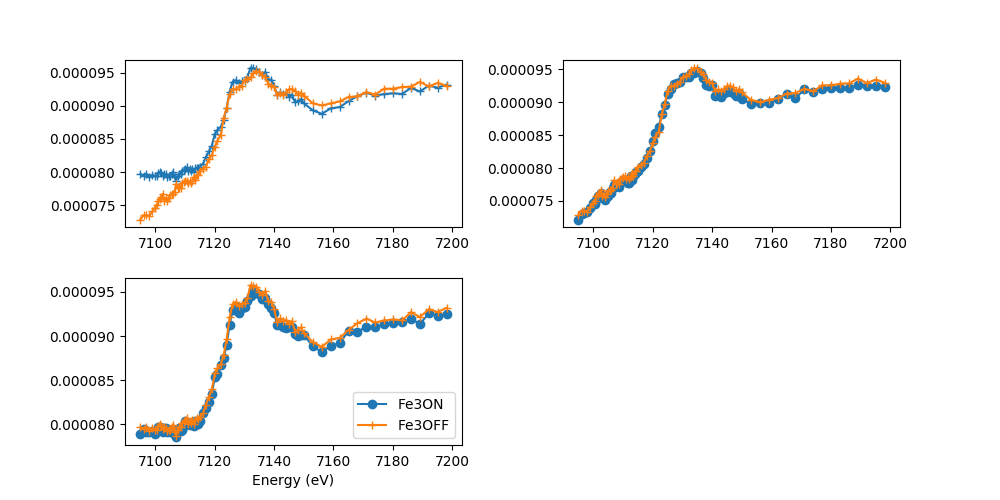

In [84]:
plt.figure(figsize = (10,5))

plt.subplot(2,2,1)
plt.plot(Energy_eV, Signal_unpump_norm, label="Fe3OFF",marker='+')
plt.plot(Energy_eV, Signal_unpump_norm1, label="Fe2OFF",marker='+')

plt.subplot(2,2,2)
plt.plot(Energy_eV, Signal_pump_norm1, label="Fe2ON",marker='o')
plt.plot(Energy_eV, Signal_unpump_norm1, label="Fe2OFF",marker='+')

plt.subplot(2,2,3)
plt.plot(Energy_eV, Signal_pump_norm, label="Fe3ON",marker='o')
plt.plot(Energy_eV, Signal_unpump_norm, label="Fe3OFF",marker='+')





#plt.xlabel("Position (mm)")
plt.xlabel("Energy (eV)")
plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.3,hspace = 0.3) 
plt.show()

#plt.savefig('Timescan_7_diode')